In [92]:
import cv2
import numpy as np 
import math
import matplotlib.pyplot as plt 
import matplotlib


def mask_color(frame, color_list, color, min_edge_threshold=100, max_edge_threshold=200):
    '''
    Makes a color mask for two colors
    Applies the mask to the image
    1) Returns the masked image
    2) Returns the edges of the image
    '''

    white = [[220,220,220],[255,255,255]]
    # Trial for HSV coding (doesn't work right now)
    orange = color_list
    # orange = [[210, 140, 100], [240, 200, 180]]

    if color=='white':

        lower = np.array(white[0])
        upper = np.array(white[1])

    elif color=='orange':
        lower = np.array(orange[0])
        upper = np.array(orange[1])

    mask = cv2.inRange(frame, lower ,upper)
    output = cv2.bitwise_and(frame, frame, mask = mask)

    edges = cv2.Canny(output, min_edge_threshold, max_edge_threshold)
    # cv2.imwrite('images.jpg', output)

    return output, edges



#  
def region_of_interest(edges):

    '''
    Crops the image in the region of interest
    Returns the edges of the cropped image
    '''

    height, width = edges.shape
    mask = np.zeros_like(edges)


    # Make a rectangle to mask the region of interest in the image
    # In this case it masks out the bottom 2/5 part of the image with width equal to the image width
    rect_mask = np.array([[
        (0, height * 1.8 / 5),
        (width, height * 1.8 / 5),
        (width, height * 3 / 5),
        (0, height * 3 / 5),
    ]], np.int32)
    

    # Fill the masked part of the image with black color 
    cv2.fillPoly(mask, rect_mask, 255)

    # Find the edges of the cropped image
    cropped_edges = cv2.bitwise_and(edges, mask)

    return cropped_edges



def detect_line_segments(cropped_edges, rho=5, angle=np.pi / 180, min_threshold=5, minLineLength=8, maxLineGap=4):
    '''
    Returns the line segments calculated by an edges image 
    (In our case it is the edges of the cropped image)
    '''

    line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                    np.array([]), minLineLength, maxLineGap)

    return line_segments



def make_points(frame, line):
    '''
    Returns a list of the beginning and end points of the line segments
    '''

    height, width, _ = frame.shape
    slope, intercept = line
    # Make points between the 4/5 the 2/5 of the height of the image 
    y1 = int(height * 4 / 5)  
    y2 = int(y1 * 1 / 2)  
    if slope != 0 :
    # bound the coordinates within the frame
        x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
        x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    if slope ==0 : 
        slope = 0.01
        x1 = 0
        x2 = 0
    return [x1, y1, x2, y2]



def lane_lines_calculation(frame, line_segments):
    '''
    Returns the lane lines from combining line segments
                            ---Note---
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    '''
    lane_lines = []
    if line_segments is None:
        print ('No line segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    fit_list = []

    

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                # print ('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]

            fit_list.append((slope,intercept))
    fit_list_avg = np.average(fit_list, axis=0)
    lane_lines.append(make_points(frame, fit_list_avg))

    print(lane_lines)
    y_offset = -(lane_lines[0][1] - lane_lines[0][3])
    x_offset = lane_lines[0][0] - lane_lines[0][2]

    steering_angle = math.atan(y_offset / x_offset)

    print(lane_lines, steering_angle)

  

    return lane_lines, steering_angle






def load_image(path, convert=True):
    img_bgr = cv2.imread(path)
    if convert:
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    else:
        img = img_bgr
    return img








def display_lines(frame, lines, steering_angle, line_color=(0, 255, 0), steering_line_color=(255, 0, 0), line_width=80):
    '''
    Returns the frame with the lane lines and a line which visulizes the steering angle
    The line which resembles the steering angle always starts at the center bottom of the frame

        ---------------Note--------------- 
            0-89 degree: turn left
            90 degree: going straight
            91-180 degree: turn righ
        ----------------------------------
    '''

    line_image = np.zeros_like(frame)
    line_image2 = np.zeros_like(frame)
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape


    steering_angle_radian = -steering_angle
    x1 = int(width / 2)
    y1 = height
    x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
    y2 = int(height / 2)

    cv2.line(heading_image, (x1, y1), (x2, y2), steering_line_color, line_width)
    

    for x1, y1, x2, y2 in lines:
        cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)

    line_image = cv2.addWeighted(frame, 0, line_image, 1, 1)
    steering_angle_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)
    final_image = cv2.addWeighted(line_image, 1, steering_angle_image, 1, 1)
    plt.imshow(final_image)
    return final_image




def auto_guide(frame, color_list, show_plot_flag=False):
    
    # img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    output, edges = mask_color(img, color_list, color='orange', min_edge_threshold=110, max_edge_threshold=330)
    cropped_edges = region_of_interest(edges)
    lane = detect_line_segments(cropped_edges, rho=10, angle=np.pi / 180, min_threshold=5, minLineLength=10, maxLineGap=5)
    lane_lines, steering_angle = lane_lines_calculation(img, lane)
   

    if show_plot_flag:
        display_lines(output, lane_lines, steering_angle, line_width=40)
    else:
        pass


    return steering_angle


[[-685, 1971, 1114, 985]]
[[-685, 1971, 1114, 985]] 0.501369671653533
0.501369671653533


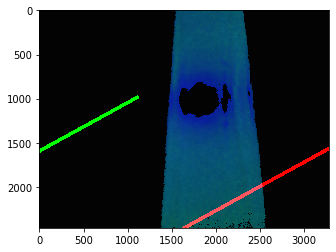

In [166]:
path = 'orange_0.jpg'
img = load_image(path, convert=True)
colorlist = [[1, 30, 100], [30, 200, 255]]
steering_angle = auto_guide(img, color_list=colorlist, show_plot_flag=True)
print(steering_angle)

# output_img, output_edges = mask_color(img, color_list=colorlist, color="orange")
# plt.imshow(output_img)